In [1]:
from datasets import load_dataset
import pandas as pd
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_sequence
from torch import Tensor
from transformers import AutoTokenizer, AutoModel
from torch.utils.data import DataLoader, Dataset 
import torch
import torch.nn as nn
from tqdm import tqdm
import csv
import numpy as np
import matplotlib.pyplot as plt

d:\Unversity\KeyValueMemory\kv_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
data = load_dataset("antareepdey/Patient_doctor_chat")
datasets = [i['Text'] for i in data['train']]
patient_query = []
doctor_response = []
patient_query_val = []
doctor_response_val = []

for i in range(1000):
    inputs, outputs = datasets[i].split("###Output:")
    patient_query.append(inputs.replace("###Input:",""))
    doctor_response.append(outputs)
for i in range(1000,1200):
    inputs, outputs = datasets[i].split("###Output:")
    patient_query_val.append(inputs.replace("###Input:",""))
    doctor_response_val.append(outputs)

data = {"Patient query": patient_query, "Doctor response": doctor_response}
val_data = {"Patient query": patient_query_val, "Doctor response": doctor_response_val}
df = pd.DataFrame(data=data)
val_df = pd.DataFrame(data=val_data)
def preprocess_data(text):
    # preprocess
    text = text.lower()
    text = text.replace('?','')
    text = text.replace("'","")
    text = text.replace("1)"," ")
    text = text.replace("2)"," ")
    text = text.replace("3)"," ")
    text = text.replace("4)"," ")
    text = text.replace("."," ")
    text = text.strip()
    return text

df['Patient query'] = df['Patient query'].apply(preprocess_data)
df['Doctor response'] = df['Doctor response'].apply(preprocess_data)

val_df['Patient query'] = val_df['Patient query'].apply(preprocess_data)
val_df['Doctor response'] = val_df['Doctor response'].apply(preprocess_data)

tokenizer = AutoTokenizer.from_pretrained('Qwen/Qwen3-Embedding-0.6B', padding_side='left')
embed_model = AutoModel.from_pretrained('Qwen/Qwen3-Embedding-0.6B')


# make own tokens 

In [3]:
all_text_data = patient_query + doctor_response + patient_query_val + doctor_response_val

In [4]:
len(all_text_data)

2400

In [5]:
used_token_ids = set()
for target_text in all_text_data:
    tokens = tokenizer.encode(target_text, add_special_tokens=False)
    used_token_ids.update(tokens)

In [6]:
used_token_ids

{0,
 1,
 4,
 65541,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 98328,
 30,
 65566,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 32803,
 42,
 43,
 44,
 45,
 46,
 47,
 32816,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 32824,
 57,
 32818,
 59,
 56,
 61,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 98378,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 32853,
 32861,
 32864,
 32869,
 65640,
 98412,
 65646,
 65659,
 32894,
 65670,
 32903,
 32907,
 65687,
 65696,
 98467,
 32932,
 98478,
 32949,
 98494,
 32967,
 32970,
 65739,
 32972,
 41,
 32983,
 220,
 32988,
 32992,
 98541,
 98547,
 258,
 259,
 261,
 263,
 264,
 265,
 266,
 267,
 268,
 269,
 270,
 65806,
 272,
 273,
 274,
 275,
 276,
 277,
 278,
 279,
 33041,
 281,
 282,
 33045,
 283,
 285,
 33053,
 287,
 288,
 289,
 290,
 291,
 292,
 293,
 294,
 295,
 296,
 297,
 33060,
 299,
 300,
 301,
 302,
 303,
 304,
 305,
 306,
 307,
 308,
 309,
 311,
 312,
 315,


In [7]:
special_ids = [tokenizer.pad_token_id, tokenizer.eos_token_id]
used_token_ids.update([tid for tid in special_ids if tid is not None])

In [8]:
maxlength = 8192
start_token = tokenizer(
        '<|im_start|>',
       add_special_tokens=False
    )['input_ids']
start_token

[151644]

In [9]:
used_token_ids.update(start_token)

In [10]:
len(used_token_ids)

10709

In [11]:
token_id_list = sorted(list(used_token_ids))
old2new = {old: new for new, old in enumerate(token_id_list)}
new2old = {v: k for k, v in old2new.items()}

#custom dataset

In [3]:
class CustomDataset(Dataset):
    def __init__(self, data):
        self.data = data
        self.max_length = 8192

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        question = df.iloc[index]['Patient query']
        answer = df.iloc[index]['Doctor response']

        question_ids = tokenizer(
            question,
            truncation=True,
            max_length=self.max_length,
            add_special_tokens=False,
            return_tensors="pt"
        )['input_ids'][0] 

        answer_ids = tokenizer(
            answer,
            truncation=True,
            max_length=self.max_length,
             add_special_tokens=False,
            return_tensors="pt"
        )['input_ids'][0]

        return question_ids, answer_ids


In [ ]:
# def collate_fn(batch):
#     questions, answers = zip(*batch) 

#     padded_questions = pad_sequence(questions, batch_first=True, padding_value=tokenizer.pad_token_id)
#     padded_answers = pad_sequence(answers, batch_first=True, padding_value=tokenizer.pad_token_id)

#     return padded_questions, padded_answers


In [4]:
dataset = CustomDataset(df) 
val_dataset = CustomDataset(val_df)

In [5]:
train_loader = DataLoader( dataset, batch_size=1, shuffle=True)
val_loader = DataLoader( val_dataset, batch_size=1,  shuffle=True)

In [6]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [7]:
class EncoderDecoderWithKBAttention(nn.Module):
    def __init__(self, embed_model, vocab_size, hidden_dim, embedding_dim=1024):
        super().__init__()
        self.embed_model = embed_model
        self.encoder = nn.LSTM(embedding_dim, hidden_dim, dropout=0.2, batch_first=True, bidirectional=True)
        self.decoder = nn.LSTMCell(embedding_dim, hidden_dim * 2)

        # Attention over encoder outputs
        self.W_denc1 = nn.Linear(hidden_dim * 4, hidden_dim)
        self.W_denc2 = nn.Linear(hidden_dim, hidden_dim)
        self.w = nn.Linear(hidden_dim, 1)

        # Attention over KB keys (commented out, unused)
        # self.W_kb1 = nn.Linear(hidden_dim + embedding_dim, hidden_dim)
        # self.W_kb2 = nn.Linear(hidden_dim, hidden_dim)
        # self.r = nn.Linear(hidden_dim, 1)

        # Final vocab projection
        self.U = nn.Linear(hidden_dim * 4, vocab_size)

        self.vocab_size = vocab_size

    def decoder_attention(self, decoder_hidden, encoder_hidden):
        B, T, H = encoder_hidden.shape  # B=batch, T=encoder seq len, H=hidden size
        decoder_exp = decoder_hidden.unsqueeze(1).expand(-1, T, -1)  # (B, T, H)
        combined = torch.cat([encoder_hidden, decoder_exp], dim=2)  # (B, T, 2H)
        x = torch.tanh(self.W_denc1(combined))                      # (B, T, H)
        x = torch.tanh(self.W_denc2(x))                             # (B, T, H)
        u = self.w(x).squeeze(-1)                                   # (B, T)
        attn = torch.softmax(u, dim=1)                              # (B, T)

        context = torch.bmm(attn.unsqueeze(1), encoder_hidden).squeeze(1)  # (B, H)
        concat = torch.cat([decoder_hidden, context], dim=1)          # (B, 2H)
        vocab_logits = self.U(concat)                                 # (B, vocab_size)
        return vocab_logits

    def forward(self, inputs, targets, teacher_forcing_ratio=1.0, kb_keys=None, fine_tune=False):
    

        batch_size, T_out, _ = targets.shape

        enc_out, (h_enc, c_enc) = self.encoder(inputs)  # enc_out: (B, T_in, H)
        hidden = torch.cat([h_enc[0], h_enc[-1]], dim=-1)  # (B, hidden_dim*2)
        cell = torch.cat([c_enc[0], c_enc[-1]], dim=-1)    # (B, hidden_dim*2)

        logits = []

        dec_input = targets[:, 0, :]  # Initial decoder input (usually <sos> embedding)

        for t in range(1, T_out):
            hidden_state, cell_state = self.decoder(dec_input, (hidden, cell))
            hidden = hidden_state
            cell = cell_state

            hidden_logits = self.decoder_attention(hidden_state, enc_out)
            logits.append(hidden_logits)

            # Decide whether to do teacher forcing this step
            use_teacher_forcing = (torch.rand(1).item() < teacher_forcing_ratio)

            if use_teacher_forcing:
                # Use ground-truth target embedding for next input
                dec_input = targets[:, t, :]
            else:
                # Use model prediction:
                pred_tokens = torch.argmax(hidden_logits, dim=1)  # (B,)
                with torch.no_grad():
                    # Get embeddings for predicted tokens
                    # Assuming embed_model accepts token IDs and returns embeddings
                    dec_input = self.embed_model(pred_tokens)['last_hidden_state'][:, 0, :]

        return torch.stack(logits, dim=1)  # (B, T_out-1, vocab_size)


In [8]:
vocab_size = len(tokenizer.vocab)
model = EncoderDecoderWithKBAttention(embed_model=embed_model, vocab_size=vocab_size, hidden_dim=320, embedding_dim=1024).to(device)

d:\Unversity\KeyValueMemory\kv_env\lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


In [29]:
start_token

[151644]

In [20]:
embed_model

Qwen3Model(
  (embed_tokens): Embedding(151669, 1024)
  (layers): ModuleList(
    (0-27): 28 x Qwen3DecoderLayer(
      (self_attn): Qwen3Attention(
        (q_proj): Linear(in_features=1024, out_features=2048, bias=False)
        (k_proj): Linear(in_features=1024, out_features=1024, bias=False)
        (v_proj): Linear(in_features=1024, out_features=1024, bias=False)
        (o_proj): Linear(in_features=2048, out_features=1024, bias=False)
        (q_norm): Qwen3RMSNorm((128,), eps=1e-06)
        (k_norm): Qwen3RMSNorm((128,), eps=1e-06)
      )
      (mlp): Qwen3MLP(
        (gate_proj): Linear(in_features=1024, out_features=3072, bias=False)
        (up_proj): Linear(in_features=1024, out_features=3072, bias=False)
        (down_proj): Linear(in_features=3072, out_features=1024, bias=False)
        (act_fn): SiLU()
      )
      (input_layernorm): Qwen3RMSNorm((1024,), eps=1e-06)
      (post_attention_layernorm): Qwen3RMSNorm((1024,), eps=1e-06)
    )
  )
  (norm): Qwen3RMSNorm((102

In [ ]:
for input, target in train_loader:
    input = embed_model(input)['last_hidden_state']
    #print(input.shape)
    #print(target.shape)
    batch_size = target.shape[0]
    target = torch.cat([start_token[:,0].repeat(batch_size, 1),target] , dim=1)
    #print(target.shape)
    outputs = embed_model(target)['last_hidden_state']
    #print(outputs)
    #print(outputs.shape)
    #print(input.shape)
    #print(input)
    input = input.to(device)
    outputs = outputs.to(device)
    target = target.to(device)
    logits =  model(input, outputs)
    # #print(target[0][1:].unsqueeze(0).shape)
    print(logits.shape)
    print(target.shape)
    break
    

torch.Size([8, 173, 151669])
torch.Size([8, 174])


In [9]:
learning_rate = 0.001
epochs = 25
criterion = nn.CrossEntropyLoss()
#weight_decay = 1e-2
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [10]:
maxlength = 8192
start_token = tokenizer(
        '<|im_start|>',
        max_length= maxlength,
        return_tensors="pt",
    )['input_ids']

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


In [11]:
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

monitor_csv = 'new_monitor.csv'

with open(monitor_csv, mode='w', newline='') as f:
    writer = csv.writer(f)
    writer.writerow(['epoch', 'train_loss', 'val_loss', 'train_accuracy', 'val_accuracy'])

for epoch in range(0, epochs):
    model.train()
    total_train_loss = 0.0
    total_train_correct = 0
    total_train_tokens = 0

    for input_texts, target_tokens in tqdm(train_loader, desc=f"Training Epoch {epoch+1}"):
        batch_size = target_tokens.size(0)
        
        # Prepare inputs
        input_texts = input_texts[:, :-1].to(device)
        target_with_bos = torch.cat([start_token[:, 0].repeat(batch_size, 1), target_tokens], dim=1).to(device)


        with torch.no_grad():
            input_embeds = embed_model(input_texts)['last_hidden_state']
            target_embeds = embed_model(target_with_bos)['last_hidden_state']

        input_embeds = input_embeds.to(device)
        target_embeds = target_embeds.to(device)
        target_tokens = target_tokens.to(device)

        # # Map target_tokens to reduced vocab IDs
        # target_tokens_np = target_tokens.cpu().numpy()
        # target_reduced_np = np.vectorize(lambda x: old2new.get(x, 0))(target_tokens_np)
        # target_reduced = torch.tensor(target_reduced_np, dtype=torch.long, device=target_tokens.device)

        optimizer.zero_grad()
        logits = model(input_embeds, target_embeds)

        loss = criterion(
            logits.view(-1, logits.shape[-1]),
            target_tokens.reshape(-1)
        )
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()

        preds = torch.argmax(logits, dim=-1)
        correct = (preds == target_tokens).float()
        total_train_correct += correct.sum().item()
        total_train_tokens += target_tokens.numel()

    avg_train_loss = total_train_loss / len(train_loader)
    train_accuracy = total_train_correct / total_train_tokens

    model.eval()
    total_val_loss = 0.0
    total_val_correct = 0
    total_val_tokens = 0

    with torch.no_grad():
        for input_texts, target_tokens in tqdm(val_loader, desc="Validating"):
            batch_size = target_tokens.size(0)
            target_with_bos = torch.cat([start_token[:, 0].repeat(batch_size, 1), target_tokens], dim=1)

            input_embeds = embed_model(input_texts.to(device))['last_hidden_state']
            target_embeds = embed_model(target_with_bos.to(device))['last_hidden_state']

            input_embeds = input_embeds.to(device)
            target_embeds = target_embeds.to(device)
            target_tokens = target_tokens.to(device)

            # # Map target tokens to reduced vocab IDs
            # target_tokens_np = target_tokens.cpu().numpy()
            # target_reduced_np = np.vectorize(lambda x: old2new.get(x, 0))(target_tokens_np)
            # target_reduced = torch.tensor(target_reduced_np, dtype=torch.long, device=target_tokens.device)

            logits = model(input_embeds, target_embeds)

            loss = criterion(
                logits.view(-1, logits.shape[-1]),
                target_tokens.reshape(-1)
            )
            total_val_loss += loss.item()

            preds = torch.argmax(logits, dim=-1)
            correct = (preds == target_tokens).float()
            total_val_correct += correct.sum().item()
            total_val_tokens += target_tokens.numel()

    avg_val_loss = total_val_loss / len(val_loader)
    val_accuracy = total_val_correct / total_val_tokens

    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)
    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)

    # Save model checkpoint
    torch.save(model.state_dict(), f"../models/model_weight00.pth")

    # Save metrics to CSV
    with open(monitor_csv, mode='a', newline='') as f:
        writer = csv.writer(f)
        writer.writerow([epoch + 1, avg_train_loss, avg_val_loss, train_accuracy, val_accuracy])

    print(f"Epoch {epoch + 1}, "
          f"Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, "
          f"Train Acc: {train_accuracy:.4f}, Val Acc: {val_accuracy:.4f}")


Validating: 100%|██████████| 200/200 [00:30<00:00,  6.63it/s]


Epoch 1, Train Loss: 4.4604, Val Loss: 2.9718, Train Acc: 0.2865, Val Acc: 0.3944


Validating: 100%|██████████| 200/200 [00:29<00:00,  6.71it/s]


Epoch 2, Train Loss: 2.9106, Val Loss: 2.3055, Train Acc: 0.3915, Val Acc: 0.4607


Validating: 100%|██████████| 200/200 [00:29<00:00,  6.72it/s]


Epoch 3, Train Loss: 2.3769, Val Loss: 1.9532, Train Acc: 0.4434, Val Acc: 0.5178


Validating: 100%|██████████| 200/200 [00:39<00:00,  5.10it/s]


Epoch 4, Train Loss: 2.0216, Val Loss: 1.6712, Train Acc: 0.4957, Val Acc: 0.5689


Validating: 100%|██████████| 200/200 [00:30<00:00,  6.66it/s]


Epoch 5, Train Loss: 1.7515, Val Loss: 1.4445, Train Acc: 0.5416, Val Acc: 0.6137


Validating: 100%|██████████| 200/200 [00:29<00:00,  6.74it/s]


Epoch 6, Train Loss: 1.5535, Val Loss: 1.3369, Train Acc: 0.5820, Val Acc: 0.6359


Validating: 100%|██████████| 200/200 [00:29<00:00,  6.67it/s]


Epoch 7, Train Loss: 1.3908, Val Loss: 1.1944, Train Acc: 0.6160, Val Acc: 0.6703


Validating: 100%|██████████| 200/200 [00:30<00:00,  6.52it/s]


Epoch 8, Train Loss: 1.2611, Val Loss: 1.0848, Train Acc: 0.6444, Val Acc: 0.6910


Validating: 100%|██████████| 200/200 [00:30<00:00,  6.53it/s]


Epoch 9, Train Loss: 1.1451, Val Loss: 0.9521, Train Acc: 0.6711, Val Acc: 0.7302


Validating: 100%|██████████| 200/200 [00:39<00:00,  5.05it/s]


Epoch 10, Train Loss: 1.0330, Val Loss: 0.8531, Train Acc: 0.6989, Val Acc: 0.7562


Validating: 100%|██████████| 200/200 [00:39<00:00,  5.04it/s]


Epoch 11, Train Loss: 0.9335, Val Loss: 0.8091, Train Acc: 0.7267, Val Acc: 0.7650


Validating: 100%|██████████| 200/200 [00:39<00:00,  5.07it/s]


Epoch 12, Train Loss: 0.8448, Val Loss: 0.7189, Train Acc: 0.7500, Val Acc: 0.7899


Validating: 100%|██████████| 200/200 [00:39<00:00,  5.02it/s]


Epoch 13, Train Loss: 0.7768, Val Loss: 0.6476, Train Acc: 0.7696, Val Acc: 0.8134


Validating: 100%|██████████| 200/200 [00:39<00:00,  5.12it/s]


Epoch 14, Train Loss: 0.7043, Val Loss: 0.5955, Train Acc: 0.7887, Val Acc: 0.8308


Validating: 100%|██████████| 200/200 [00:39<00:00,  5.08it/s]


Epoch 15, Train Loss: 0.6402, Val Loss: 0.5250, Train Acc: 0.8072, Val Acc: 0.8480


Validating: 100%|██████████| 200/200 [00:39<00:00,  5.03it/s]


Epoch 16, Train Loss: 0.5853, Val Loss: 0.5082, Train Acc: 0.8239, Val Acc: 0.8537


Validating: 100%|██████████| 200/200 [00:39<00:00,  5.06it/s]


Epoch 17, Train Loss: 0.5369, Val Loss: 0.4409, Train Acc: 0.8374, Val Acc: 0.8714


Validating: 100%|██████████| 200/200 [00:39<00:00,  5.07it/s]


Epoch 18, Train Loss: 0.4846, Val Loss: 0.4109, Train Acc: 0.8538, Val Acc: 0.8805


Validating: 100%|██████████| 200/200 [00:39<00:00,  5.04it/s]


Epoch 19, Train Loss: 0.4401, Val Loss: 0.3816, Train Acc: 0.8678, Val Acc: 0.8907


Validating: 100%|██████████| 200/200 [00:39<00:00,  5.08it/s]


Epoch 20, Train Loss: 0.4102, Val Loss: 0.3409, Train Acc: 0.8774, Val Acc: 0.9060


Validating: 100%|██████████| 200/200 [00:39<00:00,  5.05it/s]


Epoch 21, Train Loss: 0.3751, Val Loss: 0.3163, Train Acc: 0.8890, Val Acc: 0.9068


Validating: 100%|██████████| 200/200 [00:39<00:00,  5.04it/s]


Epoch 22, Train Loss: 0.3498, Val Loss: 0.2927, Train Acc: 0.8943, Val Acc: 0.9177


Validating: 100%|██████████| 200/200 [00:38<00:00,  5.13it/s]


Epoch 23, Train Loss: 0.3202, Val Loss: 0.2794, Train Acc: 0.9046, Val Acc: 0.9195


Validating: 100%|██████████| 200/200 [00:39<00:00,  5.12it/s]


Epoch 24, Train Loss: 0.3044, Val Loss: 0.2804, Train Acc: 0.9085, Val Acc: 0.9184


Validating: 100%|██████████| 200/200 [00:39<00:00,  5.04it/s]


Epoch 25, Train Loss: 0.2874, Val Loss: 0.2371, Train Acc: 0.9144, Val Acc: 0.9312


In [43]:
data = pd.read_csv('monitor.csv')
train_losses = data['train_loss']
val_losses = data['val_loss']
train_acc = data['train_accuracy']
val_acc = data['val_accuracy']

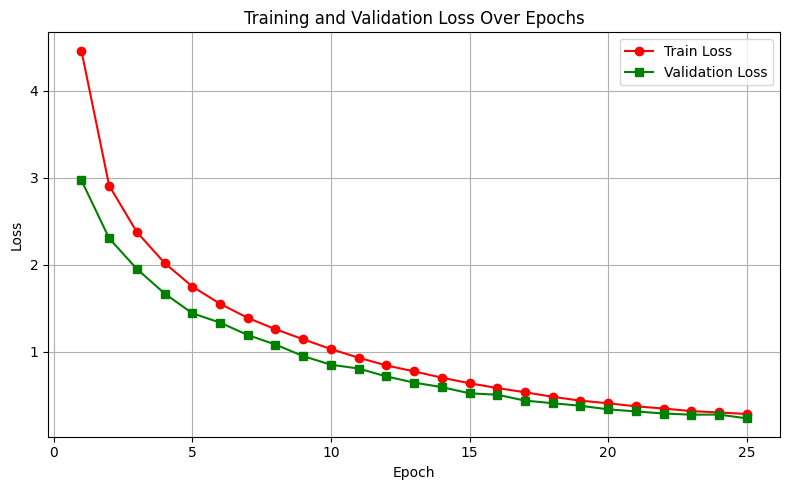

In [12]:
plt.figure(figsize=(8, 5))
plt.plot(list(range(1, epochs+1)), train_losses, label='Train Loss', marker='o', color='red')
plt.plot(list(range(1, epochs+1)), val_losses, label='Validation Loss', marker='s', color='green')

plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

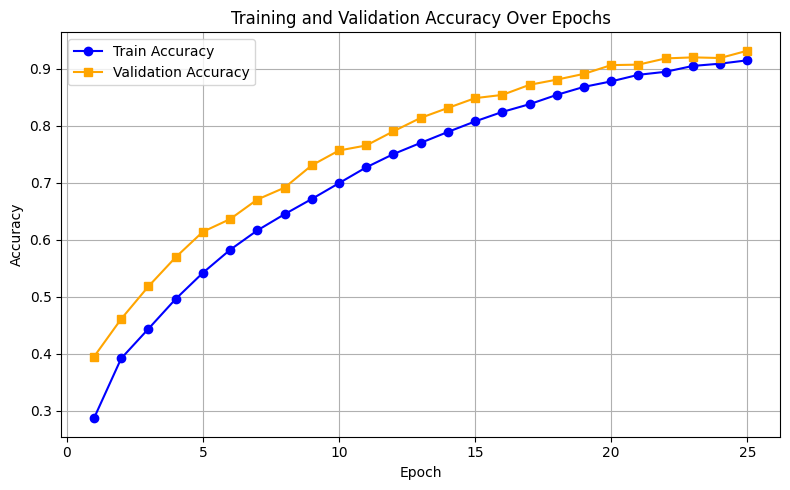

In [13]:
plt.figure(figsize=(8, 5))
plt.plot(list(range(1, epochs+1)), train_accuracies, label='Train Accuracy', marker='o', color='blue')
plt.plot(list(range(1, epochs+1)), val_accuracies, label='Validation Accuracy', marker='s', color='orange')

plt.title('Training and Validation Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

Inference

In [14]:
input = "I have a query on heavy periods since three weeks."
input = preprocess_data(input)
start_token = tokenizer(
        '<|im_start|>',
        max_length= maxlength,
        return_tensors="pt",
    )['input_ids'][:,0].unsqueeze(0).to(device)
input_tokens = tokenizer(
        input,
        max_length= maxlength,
        return_tensors="pt",
    )['input_ids'][:, :-1].to(device)

embed_model = embed_model.to(device)

embed_query = embed_model(input_tokens)['last_hidden_state'].to(device)
target = embed_model(start_token)['last_hidden_state'].to(device)


In [95]:
state_dict = torch.load("../new_models/model_weights_24.pth")
load_result = model.load_state_dict(state_dict)

In [96]:
load_result

<All keys matched successfully>

tensor([[151644]], device='cuda:0')
torch.Size([1, 10709])
torch.Size([1, 10709])


In [37]:
tokens

[16, 16]

In [45]:
tokens = torch.tensor(tokens)

In [38]:
tokenizer.convert_ids_to_tokens(tokens)

['1', '1']

In [ ]:
model.eval()
tokens = []

with torch.no_grad():
    # 1. Encode input query
    enc_out, (h_enc, c_enc) = model.encoder(embed_query.to(device))
    hidden = torch.cat([h_enc[0], h_enc[1]], dim=-1)  # (1, 2H)
    cell = torch.cat([c_enc[0], c_enc[1]], dim=-1)    # (1, 2H)

    # 2. Get embedding of <sos> token
    input_emb = embed_model(start_token.to(device))['last_hidden_state'][:, 0, :]  # (1, E)

    for i in range(20):  # Max decoding steps
        # Decode one step
        hidden, cell = model.decoder(input_emb, (hidden, cell))

        # Attention over encoder outputs
        vocab_logits = model.decoder_attention(hidden, enc_out)  
        # Predict token from reduced vocab
        pred_token = torch.argmax(vocab_logits, dim=1).item()

        # Stop if <eos> predicted
        if pred_token == tokenizer.eos_token_id:  
            break

        tokens.append(pred_token)

        next_token_tensor = torch.tensor([[pred_token]]).to(device)
        input_emb = embed_model(next_token_tensor)['last_hidden_state'][:, 0, :]

output_text = tokenizer.decode(tokens, skip_special_tokens=True)
print("Generated tokens:", tokens)
print("Generated text:", output_text, " ")


Start Token: tensor([[151644]], device='cuda:0')
Generated tokens: [6023, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16]
Generated text: hi1111111111111111111  
